In [25]:
import torch

import random

import torch
import torch.nn as nn
import torch.nn.functional as F

class Policy(nn.Module):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        # frame_stack_len is the number of contiguous frames ingested

        self.n_actions = 2  # (left, right)

        self.mlp = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=learning_rate)
        # self.scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=self.optimizer, gamma=0.9999)
    
    def forward(self, x):
        return F.sigmoid(self.mlp(x))  # returns bernoulli proba of picking left or right
    


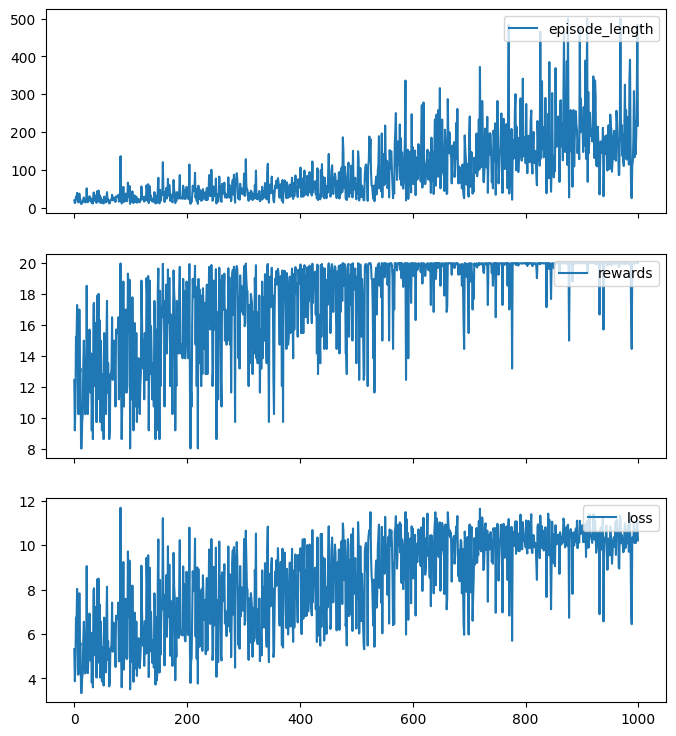

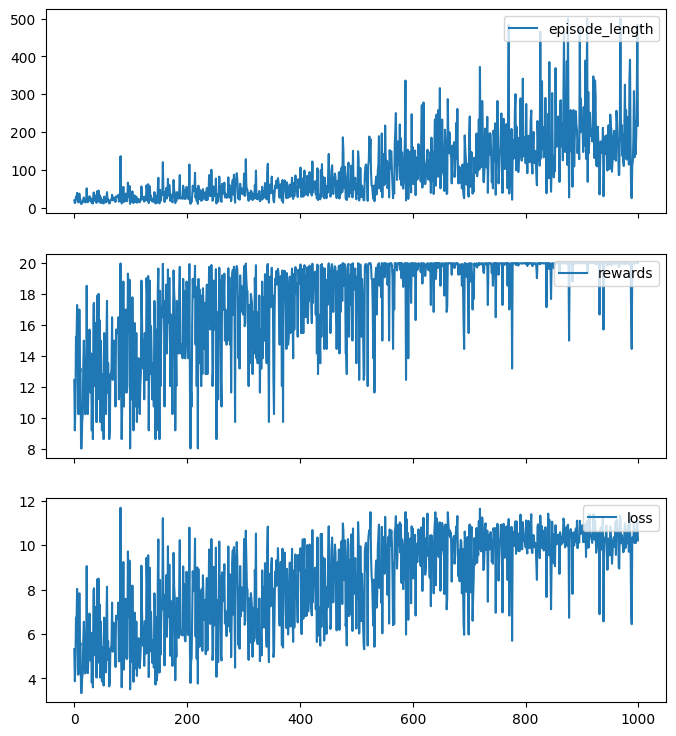

In [28]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

import gymnasium as gym
from tqdm.notebook import tqdm

def reinforce(n_episodes):
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    model = Policy(learning_rate=1e-3)
    
    metrics = {
        "episode_length": [], 
        "rewards": [],
        "loss": [],
    }
    
    plt.ion()
    fig, ax = plt.subplots(len(metrics), 1, sharex=True, figsize=(8, 3*len(metrics)))
    lines = dict()
    for i, k in enumerate(metrics.keys()):
        lines[k], = ax[i].plot([], [], label=k)
        ax[i].legend(loc="upper right")

    gamma = 0.95
    for i in tqdm(range(n_episodes)):
        episode = []
        done = False
        obs, info = env.reset()
        while not done:  # sample one episode.
            state = torch.tensor(obs)
            state = state.unsqueeze(0)  # add batch dim
            proba = model.forward(state)
            a = 0
            if random.uniform(0, 1) < proba:
                a = 1    
            obs, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            # construct batch.
            episode.append(
                (r, proba, a),  # reward, log prob of action with gradient
            )
        
        # perform gradient descent
        model.optimizer.zero_grad()
        gain = 0
        T = len(episode)
        total_loss = torch.tensor(0.)
        for i in range(1, T+1):
            r, proba, a = episode[T-i]
            # since we only consider the diagonal of the covariance matrix, we can treat the
            # actions as independent variables.
            a = torch.tensor(a, requires_grad=False)
            log_prob = torch.log(proba * a + (1 - proba) * (1 - a))
            gain = r + gamma*gain
            loss = - gain * log_prob
            total_loss += loss.sum()
        
        total_loss.backward()

        # model.scheduler.step()
        model.optimizer.step()
        metrics["rewards"].append(gain)
        metrics["episode_length"].append(T)
        metrics["loss"].append(total_loss.item()/T)
        # Update the data of the line objects
        for key, data in metrics.items():
            lines[key].set_data(range(len(data)), data)
        for i in range(len(ax)):
            ax[i].relim()  # Recalculate limits
            ax[i].autoscale_view(True,True,True)  # Rescale the axis

        clear_output(wait=True)  # Clear the output
        display(fig)  # Re-display the figure

    env.close()
    plt.ioff()
    return model

model = reinforce(n_episodes=1000)


In [29]:
from utils import sample_episode

def policy(obs):
    state = torch.tensor(obs)
    state = state.unsqueeze(0)  # add batch dim
    proba = model.forward(state)
    a = 0
    if random.uniform(0, 1) < proba:
        a = 1 
    return a

# save gif.
env = gym.make("CartPole-v1", render_mode="rgb_array")
_ = sample_episode(
    policy, 
    env=env,
    render=True
)
env.close()